# Plots trends for all percentiles, z-score for trend and mean-state, and trend map with average sst contours of percenitles 




In [4]:
# load packages 
import numpy as np
import xarray as xr
from xarray import DataTree
import matplotlib
import math


# from xmip.postprocessing import _parse_metric

import cartopy.crs as ccrs

# import xskillscore as xs
import matplotlib.pyplot as plt
%matplotlib inline
import calendar
from matplotlib.lines import Line2D

import os
import re
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.stats import norm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.patches as patches

from scipy.stats import scoreatpercentile



## Trend of all percentiles


In [6]:
# Load Data for the trend of each percentile
trend_percentile = xr.open_datatree('/Users/isabelaconde/Desktop/final_data/dt_cmip_percentiles_trend.nc')
# Trend for cobe data - change to NOAA OISST data
cobe_trend = xr.open_dataarray('/Users/isabelaconde/Desktop/ma_ncfiles/pacific/cobe_percentile_trend_pacific_lat20.nc')


In [7]:
cobe_trend

<xarray.DataArray 'trend' (area: 200)> Size: 2kB
[200 values with dtype=float64]
Coordinates:
  * area     (area) float64 2kB 0.0 0.005 0.01 0.015 ... 0.98 0.985 0.99 0.995

# Calculations

1. percentiles of multi-model-mean and obs sst map
    - NOAA
    - CMIP mmm
    - fix z-score and plot maps 
2. obs percentile trend calculation 
    - add to figure with trend of all percentile


In [9]:
# Load data

#multi-model-mean
mmm_g025 = xr.open_dataarray('/Users/isabelaconde/Desktop/final_data/cmip_mmm_1982_2020_time_avg_g025.nc')
mmm_percentile = xr.open_dataarray('/Users/isabelaconde/Desktop/final_data/cmip_mmm_1982_2020_time_avg_percentiles.nc')

# Observations

noaa_percentile_trend = xr.open_dataarray('/Users/isabelaconde/Desktop/final_data/noaa_percentile_trend.nc')
cobe_percentile_trend = xr.open_dataarray('/Users/isabelaconde/Desktop/final_data/cobe_percentile_trend.nc')
had_percentile_trend = xr.open_dataarray('/Users/isabelaconde/Desktop/final_data/had_percentile_trend.nc')

# Load data for the trend of each percentile
trend_percentile = xr.open_datatree('/Users/isabelaconde/Desktop/final_data/dt_cmip_percentiles_trend.nc')



In [10]:
mmm_g025

<xarray.DataArray 'tos' (lat: 24, lon: 144)> Size: 28kB
[3456 values with dtype=float64]
Coordinates:
  * lon      (lon) float64 1kB 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat      (lat) float64 192B -28.75 -26.25 -23.75 ... 23.75 26.25 28.75

In [3]:
models =['CESM1-CAM5',
 'CanESM2',
 'GFDL-ESM2M',
 'MPI-ESM',
 'ACCESS-ESM1-5',
 'CanESM5',
 'EC-Earth3',
 'IPSL-CM6A-LR',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM1-2-LR',
 'CESM2',
 'GFDL-SPEAR-MED']

data_tree=trend_percentile

mods = {}
for model_name, model_data in data_tree.items():
    en=[]
    for ensemble_name, ensemble_data in data_tree[model_name].items():
        en.extend([str(ensemble_name)])
    
    mods[str(model_name)]=en

do all ensemble members grey and solid color for the

In [4]:
# collect data for all ensemble members at each percentile to plot 
trend_dt=trend_percentile
model_array=[]
da=[]
# # print('converting datatree to arrays for each model')
for m in range(len(models)):
    
    sources = mods[models[m]][0:len(mods[models[m]])]
    # da=[] # initialise array for grad values
    for i in range(len(sources)):
        da.extend(trend_dt[models[m]].grad.values)


DA_all = xr.DataArray(np.squeeze(da), dims=['run','area'], coords={'run': np.linspace(0, 1, 519), 'area': np.linspace(0, 1, 100)})


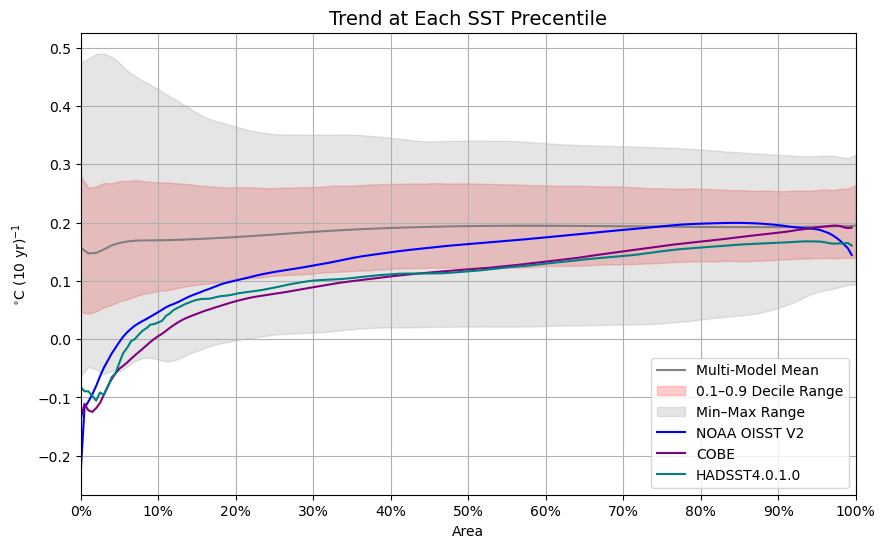

In [137]:
# Plot trend of each percentile 

# Number of percentiles 
num = 100

# Function to calculate mean and confidence intervals
def calculate_confidence_intervals_all(data, n):
    mean = np.empty(n)
    lower = np.empty(n)
    upper = np.empty(n)

    for i in range(data.shape[0]):
        mean[i] = np.mean(data[i])
        lower[i] = scoreatpercentile(data[i],10)
        upper[i] = scoreatpercentile(data[i],90)

    return mean, lower, upper

# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Set common y-axis limits
y_min = -1
y_max = 1.2

# Plot for first three models
data = DA_all.values.T * 10 * 12
mean, lower, upper = calculate_confidence_intervals_all(data, num)
df = pd.DataFrame({'mean': DA_all.mean(dim='run').values * 10 * 12, 
                   'min': DA_all.min(dim='run').values * 10 * 12, 
                   'max': DA_all.max(dim='run').values * 10 * 12, 
                   'lower': lower, 'upper': upper,
                   'area': np.linspace(0, 1, 100)})


sns.lineplot(x="area", y="mean", data=df, ax=axes, color='grey', label='Multi-Model Mean')
axes.fill_between(df['area'], df['upper'], df['lower'], alpha=0.2, color='red', label='0.1\u20130.9 Decile Range')
axes.fill_between(df['area'], df['max'], df['min'], alpha=0.2, color='grey', label='Min\u2013Max Range')

axes.plot(noaa_percentile_trend.area.values, noaa_percentile_trend.values * 10 * 12, color='blue', label='NOAA OISST V2')
axes.plot(cobe_percentile_trend.area.values, cobe_percentile_trend.values * 10 * 12, color='purple', label='COBE')
axes.plot(had_percentile_trend.area.values, had_percentile_trend.values * 10 * 12, color='teal', label='HADSST4.0.1.0')

# Modify x-axis labels to represent percentages
axes.set_xticks(np.linspace(0, 1, 11))  # 11 ticks for 0%, 10%, 20%, ..., 100%
axes.set_xticklabels(['{}%'.format(int(x * 100)) for x in np.linspace(0, 1, 11)])

# Add grid
axes.grid(True)


# Add legend
axes.legend(loc = 'lower right')
axes.set_xlim(0, 1)
axes.set_ylabel(r'$^{\circ}$C (10 yr)$^{-1}$')
axes.set_xlabel('Area')
plt.title('Trend at Each SST Precentile',fontsize=14)
plt.savefig(os.path.expanduser("~/Desktop/percents_trend_spread.pdf"), bbox_inches='tight')

plt.show()


# Plots of z-score for trend and mean-state

In [53]:
# load data

# z_score_fine = xr.open_dataarray('/Users/isabelaconde/Desktop/ma_ncfiles/z_score_cmip_interp.nc')
z_score_coarse = xr.open_dataarray('/Users/isabelaconde/Desktop/ma_ncfiles/z_score_noaa_interp.nc').sel(lat=slice(-20, 20)).sel(lon=slice(110, 300))
z_score_mean_state=xr.open_dataarray('/Users/isabelaconde/Desktop/ma_ncfiles/z_score_mean_state.nc').isel(zlev=0).sel(lat=slice(-20, 20)).sel(lon=slice(110, 300))


MM_mean= xr.open_dataset('/Users/isabelaconde/Desktop/ma_ncfiles/MM_mean.nc')

mmm= xr.open_dataset('/Users/isabelaconde/Desktop/ma_ncfiles/mmm_timeseries.nc')
mmm_ts =mmm.__xarray_dataarray_variable__
del mmm

avg_mmm = mmm_ts.mean(dim='time')


In [124]:

LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = mmm_ts.lon.values, mmm_ts.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst_g025 = mask_tot

mmm_ts_pa = mmm_ts*mask_sst_g025

mmm_ts_avg = mmm_ts_pa.mean(dim='time')
# mmm_ts_avg.plot()

In [125]:
# Load Pacific NOAA Pacific data

noaa_pa= xr.open_dataarray('/Users/isabelaconde/Desktop/Final_data/noaa_tropical-pacific_1982-2020_g0025.nc').sel(lat=slice(-20, 20)).sel(lon=slice(110, 300))
# noaa_pa.isel(time=0).plot()

In [128]:
# Find percentiles of time average noaa sst data
from xhistogram.xarray import histogram


hist_data = noaa_pa.mean(dim='time')
weights = np.cos(np.deg2rad(hist_data.lat))
const_area=np.r_[0:1:0.01]
temps = np.r_[12:34:0.5] # define temperatures for binning 

h=histogram(hist_data,bins=temps,weights=weights).cumsum()
hh = (h - h[0])/(h[-1]-h[0])
temps_interp=np.interp(const_area,hh,temps[1:])

noaa_timeavg_percentiles = xr.DataArray(temps_interp, coords ={'area':const_area})

lev=[
noaa_timeavg_percentiles.sel(area=0.05,method = 'nearest').values,
noaa_timeavg_percentiles.sel(area=0.2,method = 'nearest').values,
noaa_timeavg_percentiles.sel(area=0.5,method = 'nearest').values,
noaa_timeavg_percentiles.sel(area=0.7,method = 'nearest').values,
noaa_timeavg_percentiles.sel(area=0.9,method = 'nearest').values
]

# repeat for hist dat mmm_ts.mean(dim='time')
hist_data = mmm_ts_avg
weights = np.cos(np.deg2rad(hist_data.lat))

h=histogram(hist_data,bins=temps,weights=weights).cumsum()
hh = (h - h[0])/(h[-1]-h[0])
temps_interp=np.interp(const_area,hh,temps[1:])
mmm_timeavg_percentiles = xr.DataArray(temps_interp, coords ={'area':const_area})

lev_mmm=[
mmm_timeavg_percentiles.sel(area=0.05,method = 'nearest').values,
mmm_timeavg_percentiles.sel(area=0.2,method = 'nearest').values,
mmm_timeavg_percentiles.sel(area=0.5,method = 'nearest').values,
mmm_timeavg_percentiles.sel(area=0.7,method = 'nearest').values,
mmm_timeavg_percentiles.sel(area=0.9,method = 'nearest').values
]


In [127]:

# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = z_score_mean_state.lon.values, z_score_mean_state.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst_g025 = mask_tot

z_score_mean_state_pacific = z_score_mean_state*mask_sst_g025

In [59]:
avg_noaa_tos30 = noaa_pa.mean(dim='time')

# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = avg_noaa_tos30.lon.values, avg_noaa_tos30.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst_g0025 = mask_tot

sst_map = avg_noaa_tos30*mask_sst_g0025

In [22]:
# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = avg_noaa_tos30.lon.values, avg_noaa_tos30.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst = mask_tot

sst_map = avg_noaa_tos30*mask_sst

/var/folders/3m/hb6030nd3ml4fk_t3lq08f4w0000gn/T/ipykernel_93973/2064285341.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


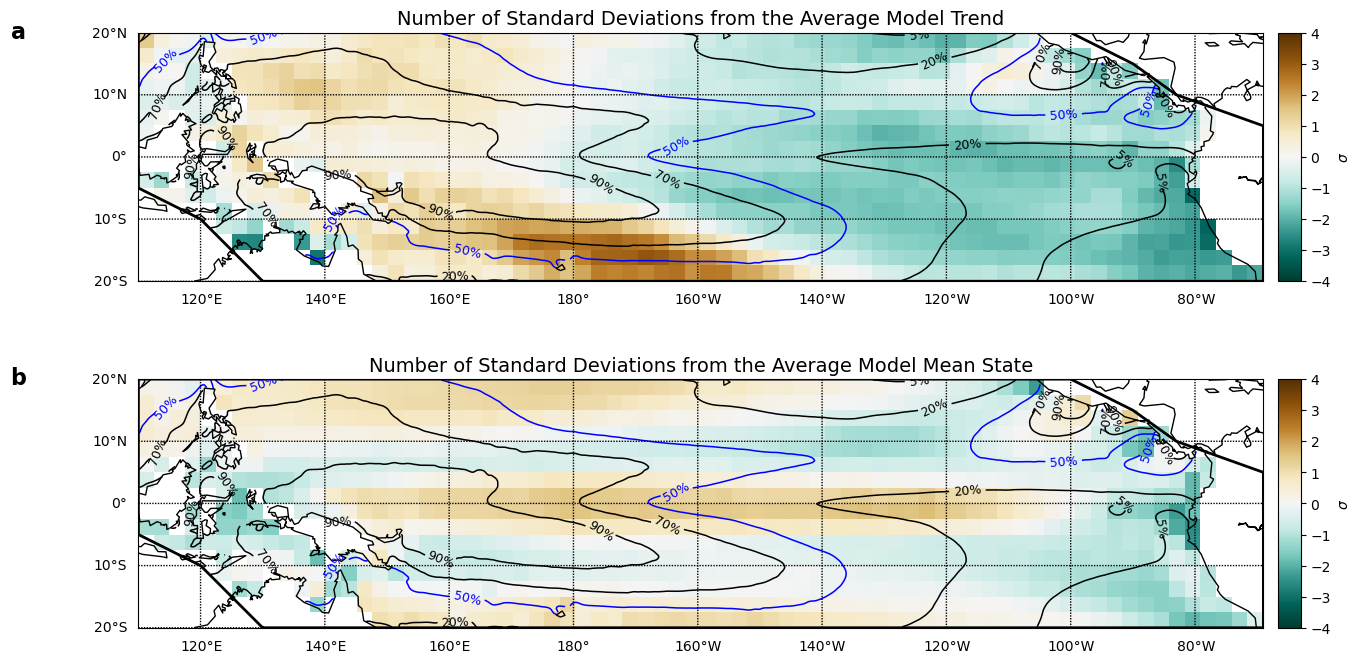

In [191]:
# plot z-scores 

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 1, figure=fig)#
gs.update(wspace=0.1, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax3 = fig.add_subplot(gs[0, 0])



z_score_map = Basemap(ax=ax3, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
z_score_map.drawcoastlines()
z_score_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
z_score_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])



# Convert latitude and longitude to map projection coordinates
x, y = z_score_map(lons, lats)

# Plot the custom outline
z_score_map.plot(x, y, marker=None, color='k', linewidth=2)


CS3=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax3, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

z_score_map.imshow(z_score_coarse.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)), cmap='BrBG_r', vmin=-4, vmax=4)
ax3.set_title('Number of Standard Deviations from the Average Model Trend', fontsize=14)

fmt = {}
strs = ['5%','20%','50%','70%','90%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='BrBG_r', norm=plt.Normalize(vmin=-4, vmax=4))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$\sigma$')



# Plot for z_score_coarse
ax4 = fig.add_subplot(gs[1, 0])
z_score_map = Basemap(ax=ax4, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
z_score_map.drawcoastlines()
z_score_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
z_score_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = z_score_map(lons, lats)

# Plot the custom outline
z_score_map.plot(x, y, marker=None, color='k', linewidth=2)


CS4=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax4, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

z_score_map.imshow(z_score_mean_state_pacific.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)), cmap='BrBG_r', vmin=-4, vmax=4)
ax4.set_title('Number of Standard Deviations from the Average Model Mean State', fontsize=14)

fmt = {}
# strs = ['5%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='BrBG_r', norm=plt.Normalize(vmin=-4, vmax=4))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$\sigma$')

# Add label 'a' for the MM_mean plot (ax3)
ax3.text(-0.1, 1.05, 'a', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add label 'b' for the NOAA OISST plot (ax4)
ax4.text(-0.1, 1.05, 'b', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()

plt.savefig(os.path.expanduser("~/Desktop/z_scores.png"), bbox_inches='tight')


/var/folders/3m/hb6030nd3ml4fk_t3lq08f4w0000gn/T/ipykernel_93973/3676959923.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


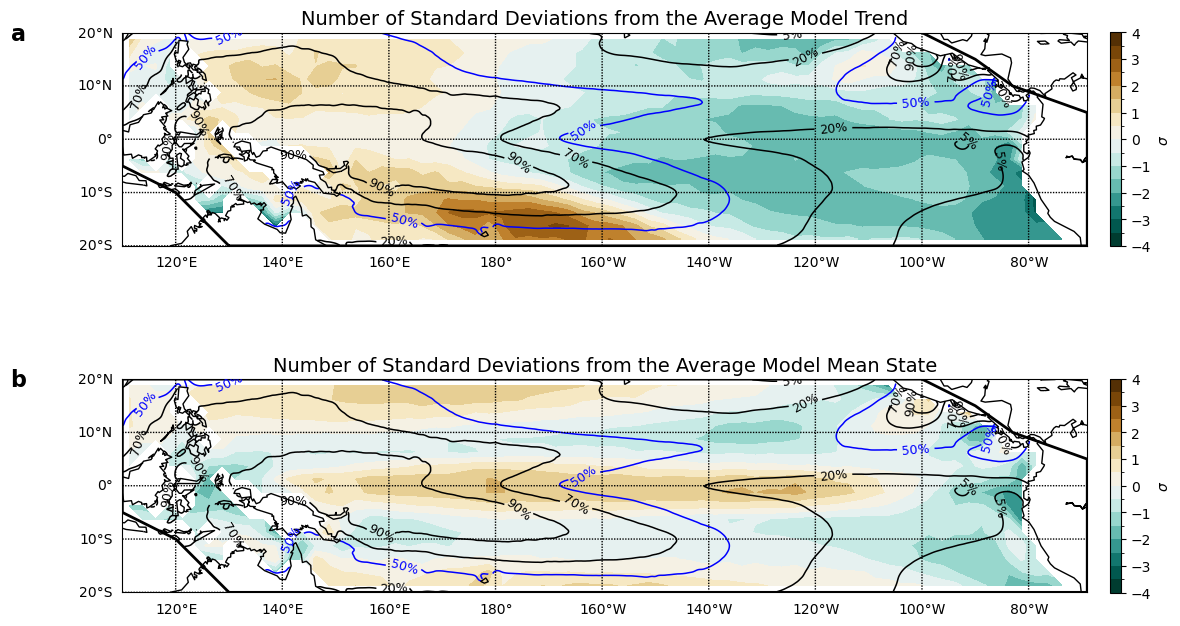

In [192]:
# plot z-scores 

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 1, figure=fig)#
gs.update(wspace=0.1, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax3 = fig.add_subplot(gs[0, 0])



z_score_map = Basemap(ax=ax3, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
z_score_map.drawcoastlines()
z_score_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
z_score_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])



# Convert latitude and longitude to map projection coordinates
x, y = z_score_map(lons, lats)

# Plot the custom outline
z_score_map.plot(x, y, marker=None, color='k', linewidth=2)



z_score_coarse.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contourf( levels=17,cmap='BrBG_r', vmin=-4, vmax=4, add_labels=False,cbar_kwargs={'label': r'$\sigma$', 'shrink': 0.37, 'pad': 0.02})
CS3=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax3, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

ax3.set_title('Number of Standard Deviations from the Average Model Trend', fontsize=14)

fmt = {}
strs = ['5%','20%','50%','70%','90%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)



# Plot for z_score_coarse
ax4 = fig.add_subplot(gs[1, 0])
z_score_map = Basemap(ax=ax4, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
z_score_map.drawcoastlines()
z_score_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
z_score_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = z_score_map(lons, lats)

# Plot the custom outline
z_score_map.plot(x, y, marker=None, color='k', linewidth=2)



z_score_mean_state_pacific.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contourf( levels=17,cmap='BrBG_r', vmin=-4, vmax=4, add_labels=False,cbar_kwargs={'label': r'$\sigma$', 'shrink': 0.37, 'pad': 0.02})
CS4=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax4, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

ax4.set_title('Number of Standard Deviations from the Average Model Mean State', fontsize=14)

fmt = {}
# strs = ['5%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add label 'a' for the MM_mean plot (ax3)
ax3.text(-0.1, 1.05, 'a', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add label 'b' for the NOAA OISST plot (ax4)
ax4.text(-0.1, 1.05, 'b', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()

plt.savefig(os.path.expanduser("~/Desktop/z_scores.png"), bbox_inches='tight')


# Maps of trends with average sst percentile contours 

In [76]:
# Load data

MM_mean= xr.open_dataset('/Users/isabelaconde/Desktop/ma_ncfiles/MM_mean.nc')
noaa_trend= xr.open_dataset('/Users/isabelaconde/Desktop/ma_ncfiles/noaa_trend.nc')

mmm= xr.open_dataset('/Users/isabelaconde/Desktop/ma_ncfiles/mmm_timeseries.nc')
mmm_ts =mmm.__xarray_dataarray_variable__
del mmm

sst_trop_weighted_lat30 = xr.open_dataarray('/Users/isabelaconde/Desktop/ma_ncfiles/sst_trop_weighted_lat30.nc').sel(time=slice('1982','2020'))

# relabel so noaa data works with percentile/quantile function
noaa_tos30 = xr.DataArray(sst_trop_weighted_lat30.isel(zlev=0),
                          coords={'time':sst_trop_weighted_lat30['time'],'lat':sst_trop_weighted_lat30['lat'],'lon':sst_trop_weighted_lat30['lon']},name='sst')#.name('sst')

avg_noaa_tos30 = noaa_tos30.mean(dim='time')

avg_mmm = mmm_ts.mean(dim='time')

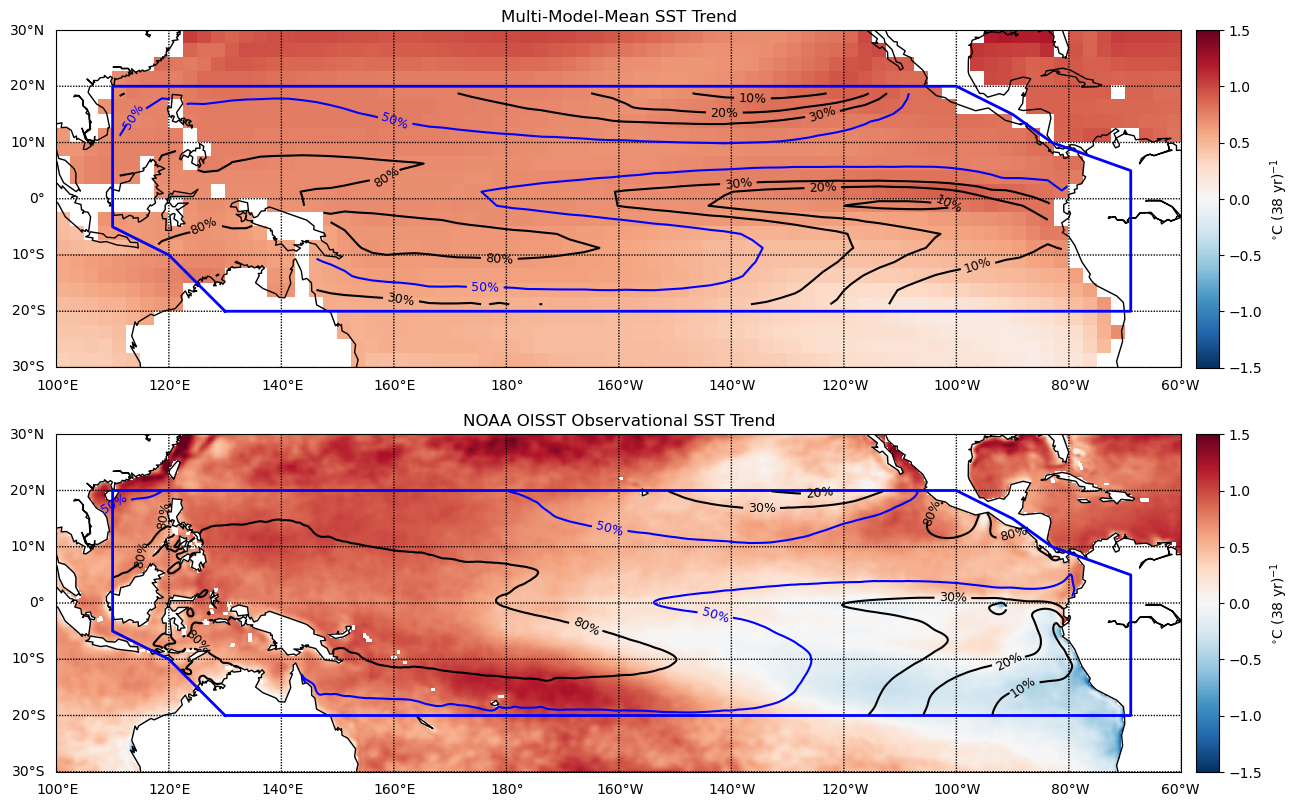

In [13]:
# Also assuming you have already calculated the gradient and multiplied by 12*38

# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = avg_mmm.lon.values, avg_mmm.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst = mask_tot

mask_mmm = mask_tot*avg_mmm

# Select the latitude range (-20 to 20) and extract the 'gradient' variable for MM_mean and noaa_trend
mm_mean_gradient = (MM_mean.gradient * 12 * 38).sel(lat=slice(-30, 30), lon=slice(100, 300))
noaa_trend_gradient = (noaa_trend.gradient * 12 * 38).sel(lat=slice(-30, 30), lon=slice(100, 300))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(2, 1, figure=fig)
gs.update(wspace=0.09, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax1 = fig.add_subplot(gs[0, 0])
mm_mean_map = Basemap(ax=ax1, width=3000000, height=35000000, projection='cyl', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=100, urcrnrlon=300, area_thresh=90000)
mm_mean_map.drawcoastlines()
mm_mean_map.drawparallels(np.arange(-30, 30.1, 10.), labels=[1, 0, 0, 0])
mm_mean_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])

# Convert latitude and longitude to map projection coordinates
x, y = mm_mean_map(lons, lats)

# Plot the custom outline
mm_mean_map.plot(x, y, marker=None, color='blue', linewidth=2)

lev=[24.17365534,25.48208866,26.38091238,27.62436595,29.16223308]
CS3=mask_mmm.sel(lat=slice(-20, 20)).sel(lon=slice(110, 300)).plot.contour(levels=lev, ax=ax1, colors=['k','k','k','blue'], zorder=2, linewidths=1.5, add_labels=False, add_colorbar=False)
mm_mean_map.imshow(mm_mean_gradient.values, cmap='RdBu_r', vmin=-1.6, vmax=1.6)
ax1.set_title('Multi-Model-Mean SST Trend')

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.5, vmax=1.5))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (38 yr)$^{-1}$')

fmt = {}
strs = ['10%','20%','30%','50%', '80%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Plot for noaa_trend
ax2 = fig.add_subplot(gs[1, 0])
noaa_trend_map = Basemap(ax=ax2, width=3000000, height=10000000, projection='cyl', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=100, urcrnrlon=300, area_thresh=10000)
noaa_trend_map.drawcoastlines()
noaa_trend_map.drawparallels(np.arange(-30, 30.1, 10.), labels=[1, 0, 0, 0])
noaa_trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])

# Convert latitude and longitude to map projection coordinates
x, y = noaa_trend_map(lons, lats)

# Plot the custom outline
noaa_trend_map.plot(x, y, marker=None, color='blue', linewidth=2)
lev=[21.51068715,23.46532366,24.8942526,26.7839437,28.5924158]
CS4=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 300)).plot.contour(levels=lev, ax=ax2, colors=['k','k','k','blue'], zorder=2, linewidths=1.5, add_labels=False, add_colorbar=False)

noaa_trend_map.imshow(noaa_trend_gradient.values, cmap='RdBu_r', vmin=-1.6, vmax=1.6)
ax2.set_title('NOAA OISST Observational SST Trend')
ax2.set_yticks([])  # Remove y-ticks

fmt = {}
strs = ['10%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.5, vmax=1.5))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (38 yr)$^{-1}$')

plt.savefig(os.path.expanduser("~/Desktop/mm_mean.png"), bbox_inches='tight')


In [74]:


# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]

sst_data = MM_mean.gradient
x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = sst_data.lon.values, sst_data.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst_trend_g025 = mask_tot

mm_mean_pa = sst_data*mask_sst_trend_g025


In [79]:

# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]

sst_data = noaa_trend.gradient
x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)

x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

temp_list = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    temp_list.append([a, b])

polygon = np.array(temp_list)

xv, yv = sst_data.lon.values, sst_data.lat.values
lon2d, lat2d = np.meshgrid(xv, yv)
points = np.hstack((lon2d.reshape((-1,1)), lat2d.reshape((-1,1))))
path = matplotlib.path.Path(polygon)
mask = path.contains_points(points)
mask.shape = lon2d.shape
mask_bit_pos = mask*np.ones_like(lon2d)


mask_tot = mask_bit_pos#+mask_bit_neg
mask_zero = mask_bit_pos

mask_tot[mask_tot==0] = np.nan
mask_sst_trend_g0025 = mask_tot

noaa_trend_pa = sst_data*mask_sst_trend_g0025
del sst_data


NameError: name 'mask_mmm' is not defined

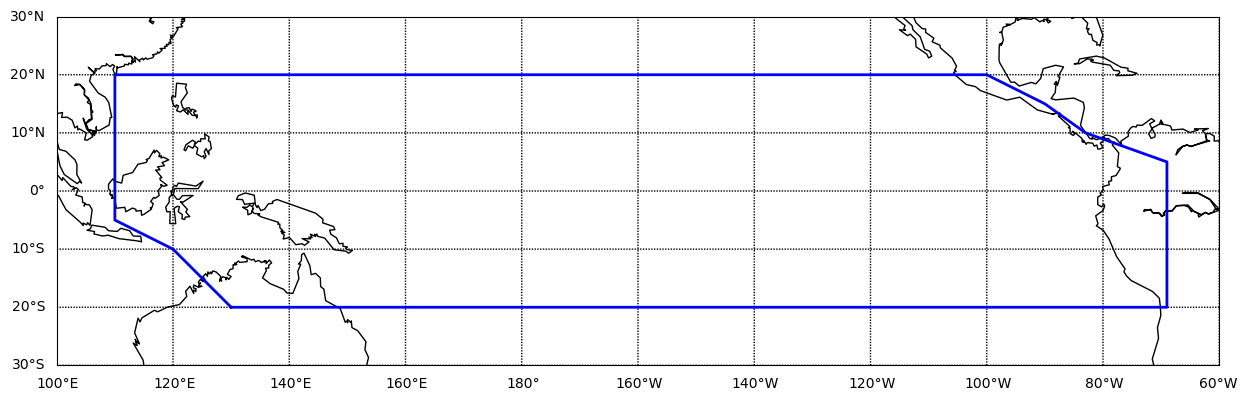

In [77]:


# Select the latitude range (-20 to 20) and extract the 'gradient' variable for MM_mean and noaa_trend
mm_mean_gradient = (mm_mean_pa.gradient * 12 * 10).sel(lat=slice(-30, 30), lon=slice(100, 300))
noaa_trend_gradient = (noaa_trend.gradient * 12 * 10).sel(lat=slice(-30, 30), lon=slice(100, 300))

# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 14))
gs = GridSpec(2, 1, figure=fig)
gs.update(wspace=0.09, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax1 = fig.add_subplot(gs[0, 0])
mm_mean_map = Basemap(ax=ax1, width=3000000, height=35000000, projection='cyl', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=100, urcrnrlon=300, area_thresh=90000)
mm_mean_map.drawcoastlines()
mm_mean_map.drawparallels(np.arange(-30, 30.1, 10.), labels=[1, 0, 0, 0])
mm_mean_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])

# Convert latitude and longitude to map projection coordinates
x, y = mm_mean_map(lons, lats)

# Plot the custom outline
mm_mean_map.plot(x, y, marker=None, color='blue', linewidth=2)

lev=[24.17365534,25.48208866,26.38091238,27.62436595,29.16223308]
CS3=mask_mmm.sel(lat=slice(-20, 20)).sel(lon=slice(110, 300)).plot.contour(levels=lev, ax=ax1, colors=['k','k','k','blue'], zorder=2, linewidths=1.5, add_labels=False, add_colorbar=False)
mm_mean_map.imshow(mm_mean_gradient.values, cmap='RdBu_r', vmin=-1.6, vmax=1.6)
ax1.set_title('Multi-Model-Mean SST Trend')

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.5, vmax=1.5))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (38 yr)$^{-1}$')

fmt = {}
strs = ['10%','20%','30%','50%', '80%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Plot for noaa_trend
ax2 = fig.add_subplot(gs[1, 0])
noaa_trend_map = Basemap(ax=ax2, width=3000000, height=10000000, projection='cyl', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=100, urcrnrlon=300, area_thresh=10000)
noaa_trend_map.drawcoastlines()
noaa_trend_map.drawparallels(np.arange(-30, 30.1, 10.), labels=[1, 0, 0, 0])
noaa_trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])

# Convert latitude and longitude to map projection coordinates
x, y = noaa_trend_map(lons, lats)

# Plot the custom outline
noaa_trend_map.plot(x, y, marker=None, color='blue', linewidth=2)
lev=[21.51068715,23.46532366,24.8942526,26.7839437,28.5924158]
CS4=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 300)).plot.contour(levels=lev, ax=ax2, colors=['k','k','k','blue'], zorder=2, linewidths=1.5, add_labels=False, add_colorbar=False)

noaa_trend_map.imshow(noaa_trend_gradient.values, cmap='RdBu_r', vmin=-1.6, vmax=1.6)
ax2.set_title('NOAA OISST Observational SST Trend')
ax2.set_yticks([])  # Remove y-ticks

fmt = {}
strs = ['10%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-1.5, vmax=1.5))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (38 yr)$^{-1}$')

plt.savefig(os.path.expanduser("~/Desktop/mm_mean.png"), bbox_inches='tight')


/var/folders/3m/hb6030nd3ml4fk_t3lq08f4w0000gn/T/ipykernel_93973/1543335079.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


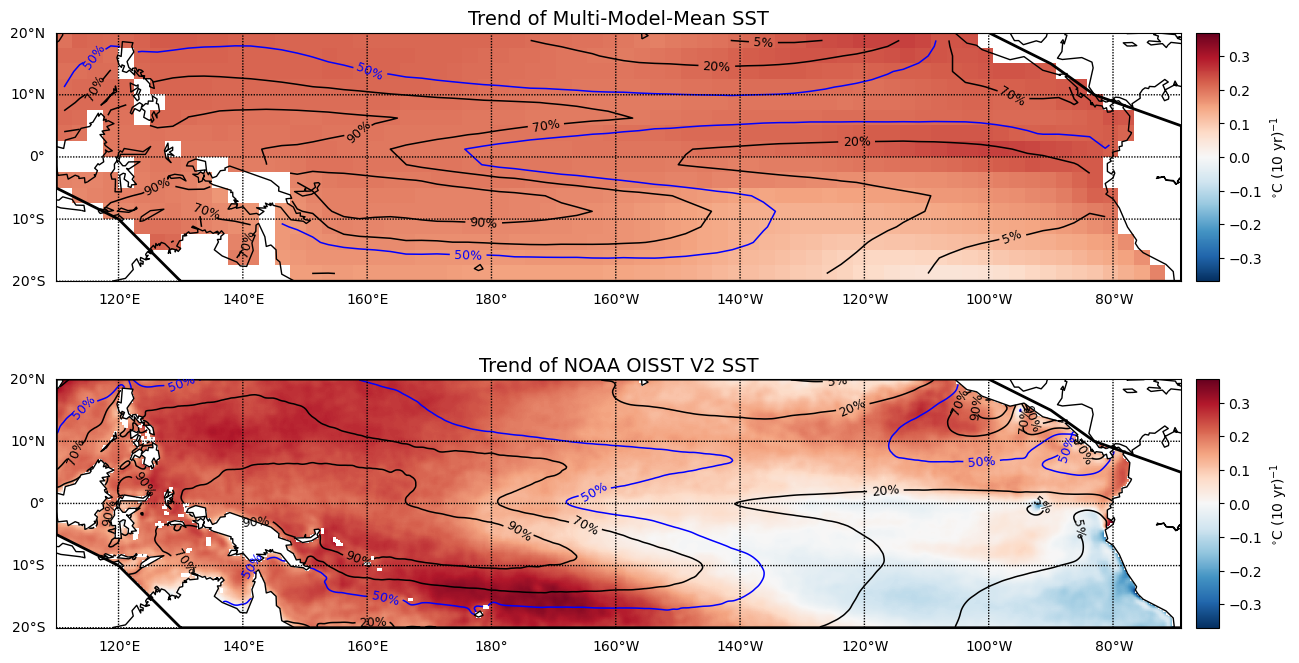

In [139]:
mm_mean_gradient = (mm_mean_pa * 12 * 10).sel(lat=slice(-20, 20), lon=slice(110, 291))
noaa_trend_gradient = (noaa_trend_pa * 12 * 10).sel(lat=slice(-20, 20), lon=slice(110, 291))

# plot trend sst maps
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 1, figure=fig)#
gs.update(wspace=0.1, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax3 = fig.add_subplot(gs[0, 0])



trend_map = Basemap(ax=ax3, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
trend_map.drawcoastlines()
trend_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = trend_map(lons, lats)

# Plot the custom outline
trend_map.plot(x, y, marker=None, color='k', linewidth=2)


CS3=mmm_ts_avg.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev_mmm, ax=ax3, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

trend_map.imshow(mm_mean_gradient, cmap='RdBu_r',vmin = -0.37,vmax=0.37)
ax3.set_title('Trend of Multi-Model-Mean SST', fontsize=14)

fmt = {}
strs = ['5%','20%','50%','70%','90%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.37, vmax=0.37))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (10 yr)$^{-1}$')



# Plot for z_score_coarse
ax4 = fig.add_subplot(gs[1, 0])
trend_map = Basemap(ax=ax4, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
trend_map.drawcoastlines()
trend_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = trend_map(lons, lats)

# Plot the custom outline
trend_map.plot(x, y, marker=None, color='k', linewidth=2)

noaa_pa_avg = noaa_pa.mean(dim='time')
CS4=noaa_pa_avg.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax4, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

trend_map.imshow(noaa_trend_gradient, cmap='RdBu_r',vmin = -0.37,vmax=0.37)
ax4.set_title('Trend of NOAA OISST V2 SST', fontsize=14)

fmt = {}
# strs = ['5%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.37, vmax=0.37))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (10 yr)$^{-1}$')


plt.tight_layout()

plt.savefig(os.path.expanduser("~/Desktop/trend_fig.png"), bbox_inches='tight')

/var/folders/3m/hb6030nd3ml4fk_t3lq08f4w0000gn/T/ipykernel_93973/220002226.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


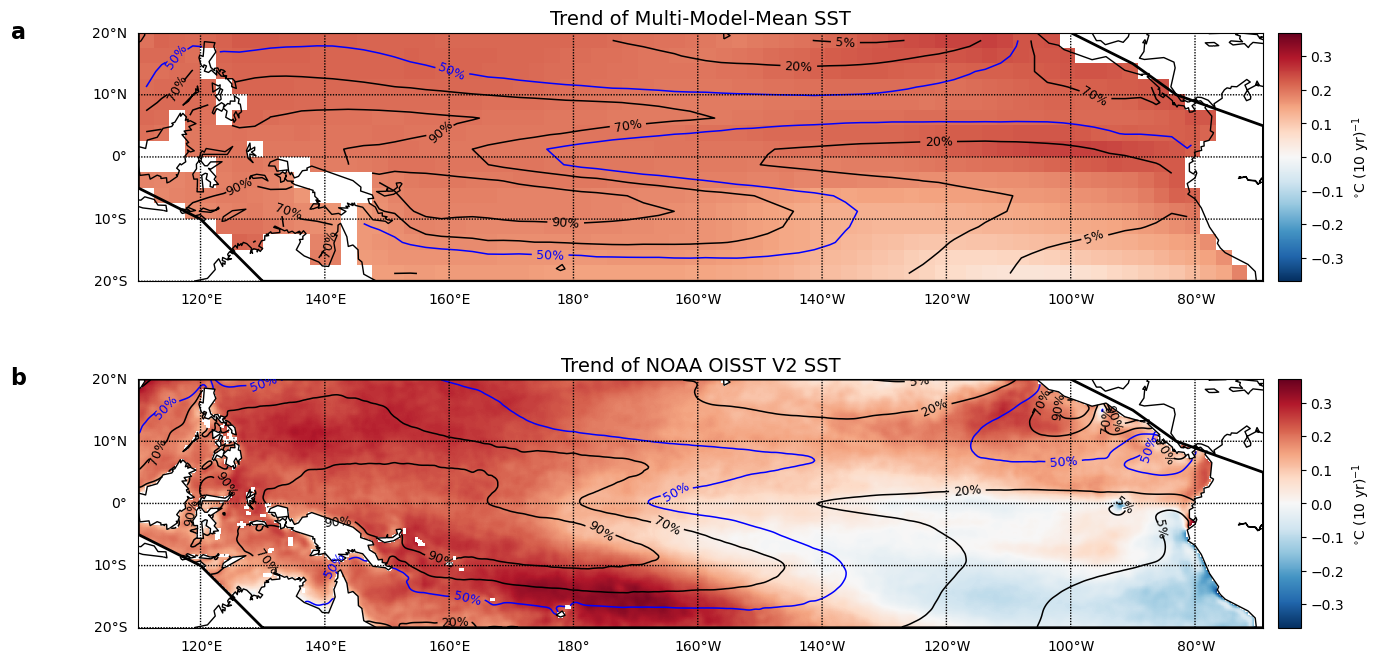

In [140]:
mm_mean_gradient = (mm_mean_pa * 12 * 10).sel(lat=slice(-20, 20), lon=slice(110, 291))
noaa_trend_gradient = (noaa_trend_pa * 12 * 10).sel(lat=slice(-20, 20), lon=slice(110, 291))

# plot trend sst maps
# Create a figure with GridSpec layout
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(2, 1, figure=fig)#
gs.update(wspace=0.1, hspace=-0.4) # set the spacing between axes. 

# Plot for MM_mean
ax3 = fig.add_subplot(gs[0, 0])



trend_map = Basemap(ax=ax3, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
trend_map.drawcoastlines()
trend_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = trend_map(lons, lats)

# Plot the custom outline
trend_map.plot(x, y, marker=None, color='k', linewidth=2)


CS3=mmm_ts_avg.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev_mmm, ax=ax3, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

trend_map.imshow(mm_mean_gradient, cmap='RdBu_r',vmin = -0.37,vmax=0.37)
ax3.set_title('Trend of Multi-Model-Mean SST', fontsize=14)

fmt = {}
strs = ['5%','20%','50%','70%','90%']
for l, s in zip(CS3.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS3, CS3.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.37, vmax=0.37))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (10 yr)$^{-1}$')



# Plot for z_score_coarse
ax4 = fig.add_subplot(gs[1, 0])
trend_map = Basemap(ax=ax4, width=6000000, height=12000000, projection='cyl', llcrnrlat=-20, urcrnrlat=20, llcrnrlon=110, urcrnrlon=291, area_thresh=10000)
trend_map.drawcoastlines()
trend_map.drawparallels(np.arange(-20, 20.1, 10.), labels=[1, 0, 0, 0])
trend_map.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])


# Convert latitude and longitude to map projection coordinates
x, y = trend_map(lons, lats)

# Plot the custom outline
trend_map.plot(x, y, marker=None, color='k', linewidth=2)

noaa_pa_avg = noaa_pa.mean(dim='time')
CS4=noaa_pa_avg.sel(lat=slice(-20, 20)).sel(lon=slice(110, 291)).plot.contour(levels=lev, ax=ax4, colors=['k','k','blue'], zorder=1, linewidths=1.1, add_labels=False, add_colorbar=False)

trend_map.imshow(noaa_trend_gradient, cmap='RdBu_r',vmin = -0.37,vmax=0.37)
ax4.set_title('Trend of NOAA OISST V2 SST', fontsize=14)

fmt = {}
# strs = ['5%','20%','30%','50%', '80%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=-0.37, vmax=0.37))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C (10 yr)$^{-1}$')

# Add label 'a' for the MM_mean plot (ax3)
ax3.text(-0.1, 1.05, 'a', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add label 'b' for the NOAA OISST plot (ax4)
ax4.text(-0.1, 1.05, 'b', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

plt.tight_layout()

plt.savefig(os.path.expanduser("~/Desktop/trend_fig.png"), bbox_inches='tight')

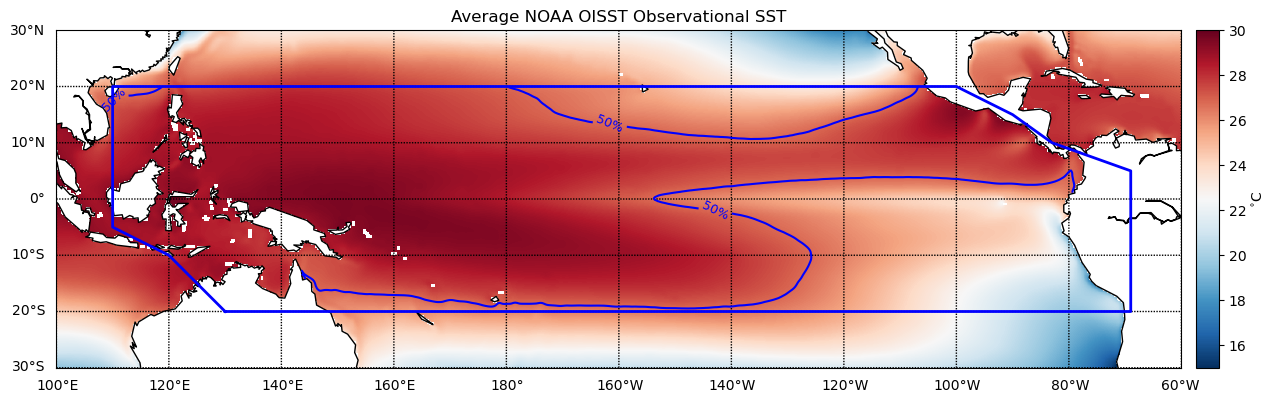

In [40]:
# Define the coordinates of the custom outline (longitude, latitude)
LonsPts_pos = [130,120,110,110,110,260,270,270,277,291,291,130] #-np.ones(13)*180
LatsPts_pos =[-20,-10,-5,10,20,20,15,15,10,5,-20,-20]


x_pixel_pos = LonsPts_pos
y_pixel_pos = LatsPts_pos

outline_coords = []
for a, b in zip(x_pixel_pos, y_pixel_pos):
    outline_coords.append([a, b])
outline_coords

# Split the coordinates into separate lists for longitude and latitude
lons, lats = zip(*outline_coords)


fig = plt.figure(figsize=(15, 14))
# gs = GridSpec(1, 1, figure=fig)
# gs.update(wspace=0.09, hspace=-0.4) # set the spacing between axes. 

# Plot for noaa_trend
ax2 = fig.add_subplot(gs[0, 0])
sst_bmap = Basemap(ax=ax2, width=3000000, height=10000000, projection='cyl', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=100, urcrnrlon=300, area_thresh=10000)
sst_bmap.drawcoastlines()
sst_bmap.drawparallels(np.arange(-30, 30.1, 10.), labels=[1, 0, 0, 0])
sst_bmap.drawmeridians(np.arange(-180., 181., 20.), labels=[0, 0, 0, 1])

# Convert latitude and longitude to map projection coordinates
x, y = sst_bmap(lons, lats)

# Plot the custom outline
sst_bmap.plot(x, y, marker=None, color='blue', linewidth=2)
lev=[26.7839437]
CS4=sst_map.sel(lat=slice(-20, 20)).sel(lon=slice(110, 300)).plot.contour(levels=lev, ax=ax2, colors=['blue'], zorder=2, linewidths=1.5, add_labels=False, add_colorbar=False)

sst_bmap.imshow(avg_noaa_tos30.sel(lat = slice(-30,30),lon = slice(100,300)).values, cmap='RdBu_r',vmin=15,vmax=30)
ax2.set_title('Average NOAA OISST Observational SST')
ax2.set_yticks([])  # Remove y-ticks

fmt = {}
strs = ['50%']
for l, s in zip(CS4.levels, strs):
    fmt[l] = s

# # Label every other level using strings
plt.clabel(CS4, CS4.levels[::1], inline=True, fmt=fmt, fontsize=9)

# Add colorbar using ScalarMappable for the last subplot
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="2%", pad=0.15)
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=plt.Normalize(vmin=15, vmax=30))
sm.set_array([])
plt.colorbar(sm, cax=cax, label=r'$^{\circ}$C')
